In [1]:
import star_functions as nana
import pandas as pd
import glob
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import numpy as np
from astropy import units as u
import matplotlib.ticker as ticker
import importlib
import os
importlib.reload(nana)
%reload_ext autoreload
%autoreload 2
from datetime import datetime
from lightkurve import LightCurve
from lightkurve import LightCurve

/Users/nana/venv/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [7]:
# packaged funtion
def star_search(kicID, plots = False, save = False):
    
    kicID = "KIC" + str(kicID).lstrip("0")
    
    lc, delta_f, sampling_time, exptime = star(kicID)
    print("kicID:", exptime)
    df, f_max, f_min = delta_f/3, (3 / (2*sampling_time)), 0.5 # magic number
    t_fit, flux_fit, weight_fit = mask_vals(lc)

    freq_full, power_full = pg_full(f_min, f_max, df, lc)
    freq_mini, power_mini = pg_mini(f_min, f_max, df, lc)

    indices = get_filtered_peaks(12, freq_mini, power_mini)
    refined_freq, refined_power, second_derivatives = refine_peaks(freq_mini, power_mini, indices)
    fc = folding_freq(delta_f, freq_full, power_full, sampling_time, False)
    regions, final_freqs, chi2s = region_and_freq(indices, fc, df, freq_mini, power_mini, t_fit, flux_fit, weight_fit, exptime)
    nulls = null_chi_squared(flux_fit, weight_fit)
    delta_chi2s = [None if c is None else nulls - c for c in chi2s]
    sharpnesses = sharpness(second_derivatives, refined_power)

    a_early, a_late, b_early, b_late = check_coherence(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    rate_of_phase, rate_of_amp = change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit) #half
    all, half, quartiles, eighths = coherence_all(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    amp_change, phase_change, sigma_lnA, sigma_phi4, sigma_phij = sampling_stats(all, quartiles, eighths)

    if save:
        date_str = datetime.now().strftime("%Y-%m-%d") 
        output_dir = os.path.join("star_outputs", f"{date_str}_{kicID}")
        os.makedirs(output_dir, exist_ok=True)
        
        data = Table()
    
    
        data['Modes'] = safe_arr(final_freqs)
        data['Regions'] = safe_arr(regions)
        data['Mode in region A'] = safe_arr(refined_freq)
        data['Sharp'] = safe_arr(sharpnesses)
        data['Delta chi2'] = safe_arr(delta_chi2s)
        data['Change of phase(2)'] = safe_arr(rate_of_phase)
        data['Change of lnA(2)'] = safe_arr(rate_of_amp)
        data['Sigma lnA(4)'] = safe_arr(sigma_lnA)
        data['Sigma phi(4)'] = safe_arr(sigma_phi4)
        data['Sigma phi(jack)'] = safe_arr(sigma_phij)
        
        
        ascii.write(
        data,
        kicID + '_stats' + '.csv',
        overwrite=True,
        format="csv",
        formats={
            "Modes": "{:.7f}",
            "Mode in region A": "{:.7f}",
            "Sharp": "{:.7e}",
            "Delta chi2": "{:.7e}",
            "Change of phase(2)": "{:.7e}",
            "Change of lnA(2)": "{:.7e}",
            "Sigma lnA(4)": "{:.7e}",
            "Sigma phi(4)": "{:.7e}",
            "Sigma phi(jack)" : "{:.7e}"
        }
        )

        output_path = os.path.join(output_dir, f"{kicID}_stats.csv")

    if plots:
        #plot lightcurve
        plt.plot(lc.time.value, lc.flux.value, color = "k")
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.title(f"Lightcurve of {kicID}")
        plt.show()
        if save:
            plt.savefig(os.path.join(output_dir, f"{kicID}_lightcurve.png"))


        plt.plot(freq_full, power_full, 'k.')
        valid_points = [(f, p) for f, p in zip(final_freqs, refined_power) if f is not None and p is not None]
        if valid_points:
            valid_freqs, valid_power = zip(*valid_points)
            plt.scatter(valid_freqs, valid_power, color='red', marker='o')
        plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
        plt.xlabel("Frequency (1/day)")
        plt.ylabel("Power")
        plt.axvline(fc)
        plt.axvline(fc/2)
        plt.title(f"Full Periodogram of {kicID}")
        plt.show()
        if save:
            plt.savefig(os.path.join(output_dir, f"{kicID}_fullperio.png"))

        plt.plot(freq_mini, power_mini, 'k.')
        plt.xlabel("Frequency (1/day)")
        plt.ylabel("Power")
        plt.title(f"Region A Periodogram of {kicID}")
        plt.show()
        if save:
            plt.savefig(os.path.join(output_dir, f"{kicID}_miniperio.png"))

        plt.plot(freq_mini, power_mini, 'k-')
        plt.xlabel("Frequency (1/day)")
        plt.ylabel("Log Power")
        plt.semilogy()
        plt.title(f"Region A Log Periodogram of {kicID}")
        plt.show()
        if save:
            plt.savefig(os.path.join(output_dir, f"{kicID}_mini_logperio.png"))
        
        #fc = folding_freq(delta_f, freq_full, power_full, sampling_time, True)

        #15 point graph
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        plt.suptitle(f"15 Point figure of {kicID}", fontsize = 18)
        
        for idx, (ax, points1, points2, points3, points4, p1, p2, p3, p4) in enumerate(zip(axes.flat, all, half, quartiles, eighths, rate_of_phase, 
                                                                                           sigma_phi4, sigma_phij, phase_change)):
            if points1 is None or points2 is None or points3 is None or points4 is None:
                ax.set_visible(False)
                continue
            
            try:
                a_all = points1[0]
                b_all = points1[1]
        
                a_half = [row[0] for row in points2 if row[0] is not None and row[1] is not None]
                b_half = [row[1] for row in points2 if row[0] is not None and row[1] is not None]
        
                a_quarter = [row[0] for row in points3 if row[0] is not None and row[1] is not None]
                b_quarter = [row[1] for row in points3 if row[0] is not None and row[1] is not None]
        
                a_eighth = [row[0] for row in points4 if row[0] is not None and row[1] is not None]
                b_eighth = [row[1] for row in points4 if row[0] is not None and row[1] is not None]
        
                ax.scatter(a_half, b_half, color='orange', marker='*')
                ax.scatter(a_quarter, b_quarter, color='blue', marker='+')
                ax.scatter(a_eighth, b_eighth, color='k', marker='.')
                ax.scatter(a_all, b_all, color='red', marker='x')
        
                p1_str = f"{p1:0.8e}" if p1 is not None else "None"
                p2_str = f"{p2:0.8e}" if p2 is not None else "None"
                p3_str = f"{p3:0.8e}" if p3 is not None else "None"
        
                ax.text(0.05, 0.95, f"phase change(2): {p1_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.88, f"sigma phi(4): {p2_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
                ax.text(0.05, 0.81, f"sigma phi(jack): {p3_str}", transform=ax.transAxes,
                        fontsize=8, verticalalignment='top', color='green')
        
                freq_label = f"{final_freqs[idx]:0.8f}" if final_freqs[idx] is not None else "None"
                ax.set_title(freq_label)
        
                ax.axvline(0, color='k')
                ax.axhline(0, color='k')
                ax.set_xlabel("a points")
                ax.set_ylabel("b points")
                ax.grid(True)
                ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
                ax.axis('equal')
        
            except Exception as e:
                ax.set_visible(False)
                continue

        
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(output_dir, f"{kicID}_15point.png"))


In [3]:
#injection functions
def injection_design_matrix(ts, freq):
    om = 2 * np.pi * freq
    return np.vstack([ np.ones_like(ts), np.sin(om * ts), np.cos(om * ts) ]).T

def inject_one_mode(ts, ys, amp=0.01, seed=17):
    #yin is the new fluxfit
    rng = np.random.default_rng(seed)
    
    ain, bin = amp * rng.normal(size=2) 
    inject_vec = np.array([0.0, ain, bin])   
    freq = rng.uniform(4, 72)

    xin = injection_design_matrix(ts, freq)
    yin = ys + xin @ inject_vec  
    
    return yin, ain, bin, freq 

In [8]:
#kic ids

#original kic id: 5202905
#other poster children stars: 9111849, 3964109
#aerts stars
# kic_ids = [
#     3240411, 3459297, 3865742, 4930889, 4936089, 4939281,
#     5309849, 5941844, 6352430, 6462033, 6780397, 7630417,
#     7760680, 8057661, 8255796, 8381949, 8459899, 8714886,
#     8766405, 9020774, 9715425, 10526294, 11360704, 11971405,
#     12258330
# ]

#random star ids: 8431263, 9956758, 5559776

#plt.ylim(0, 0.000012)

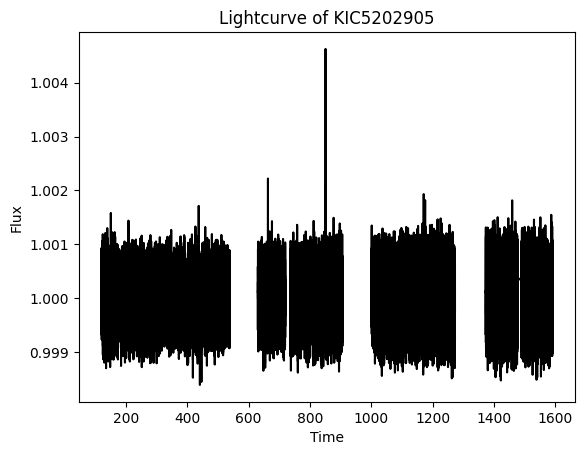

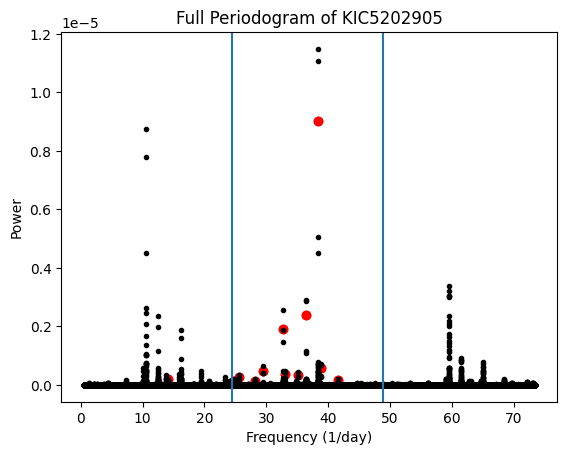

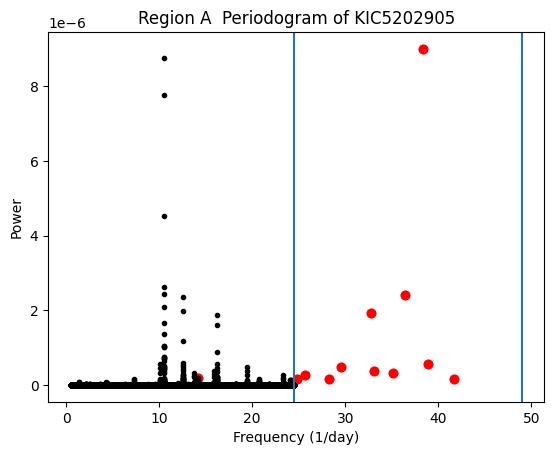

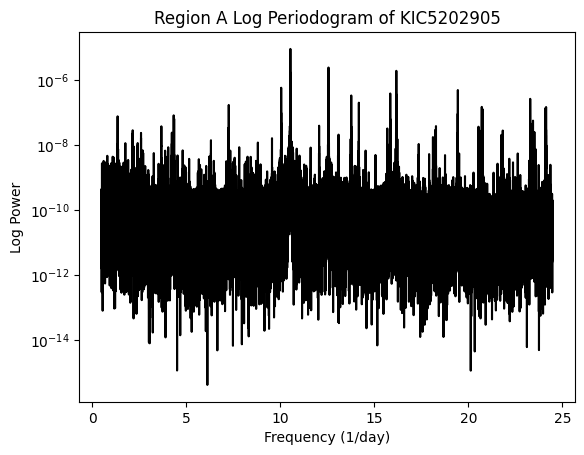

<Figure size 640x480 with 0 Axes>

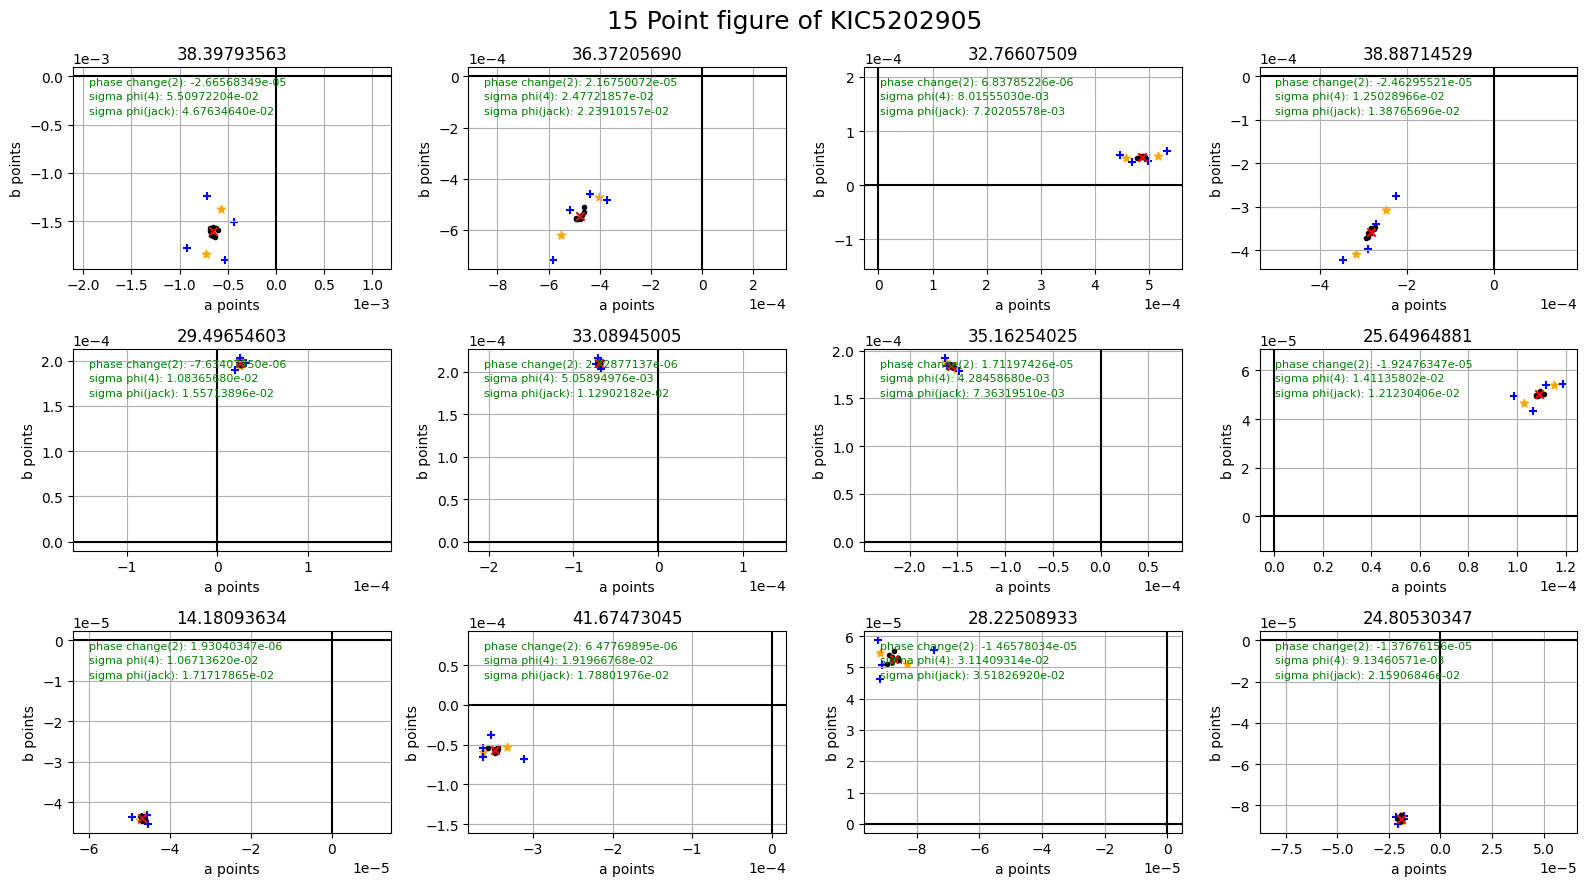

In [32]:
nana.star_search(5202905, True, True, False) #plot, save, inject

injected freq 30.236034556065498


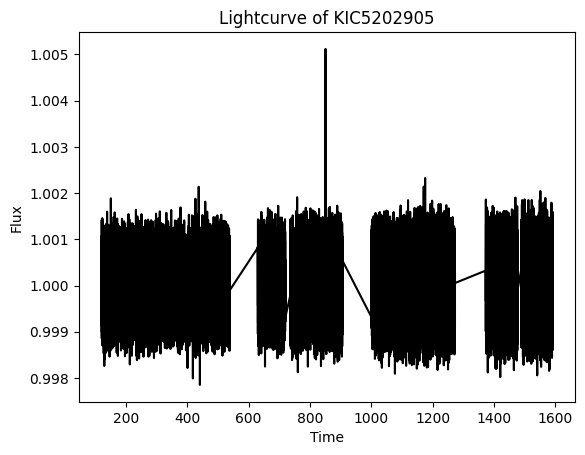

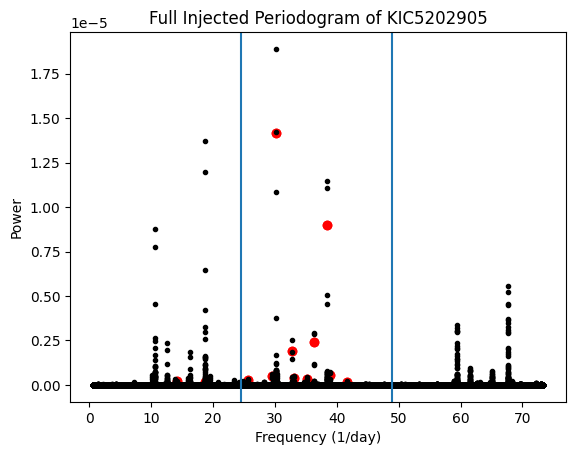

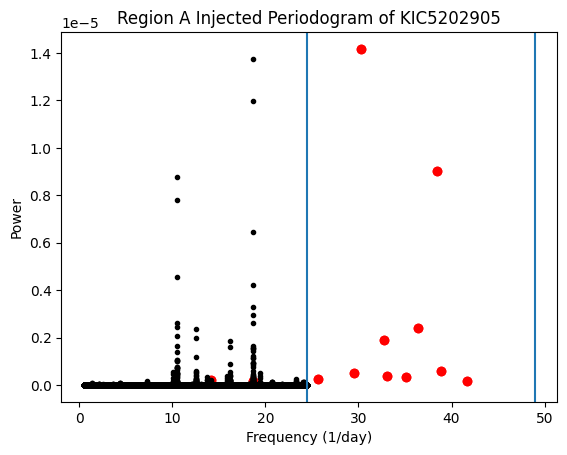

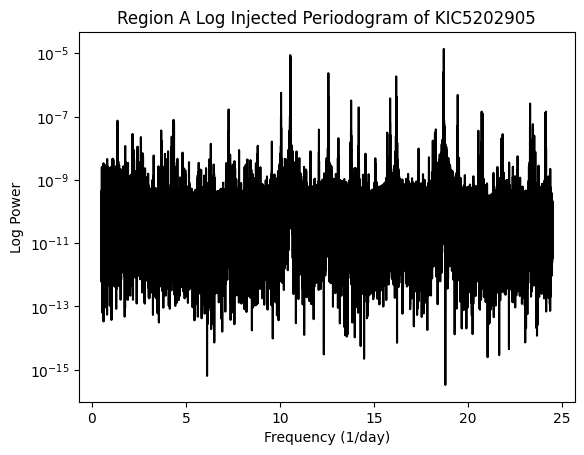

<Figure size 640x480 with 0 Axes>

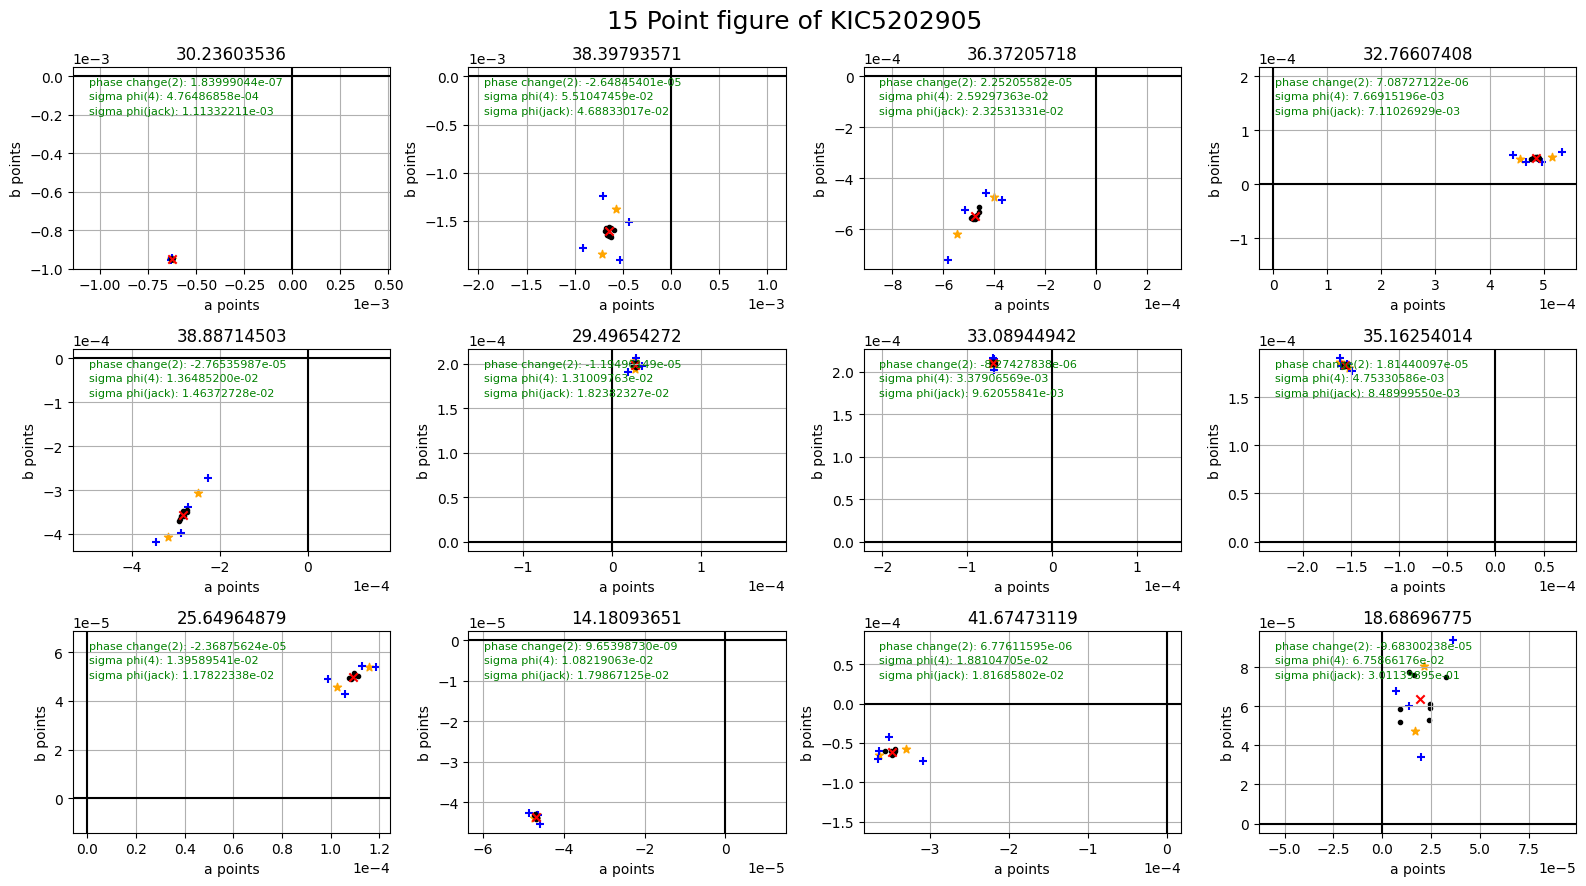

In [41]:
rng = np.random.default_rng(17)
nana.star_search(5202905, True, True, inject_rng = rng, inject_amp = 5e-4) #plot, save, inject

injection (29.748415493820243, np.float64(-0.0006124917784436158), np.float64(0.0003432270521124315))


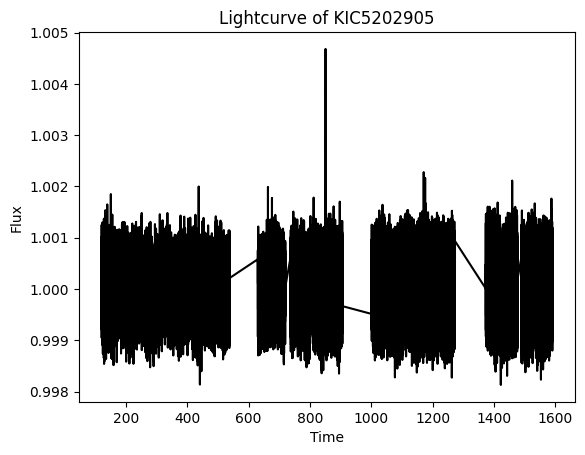

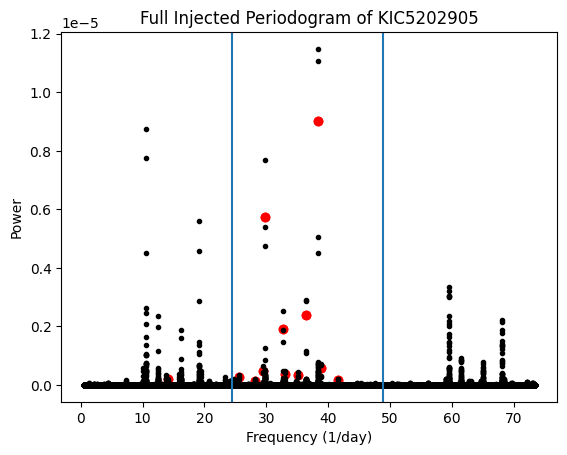

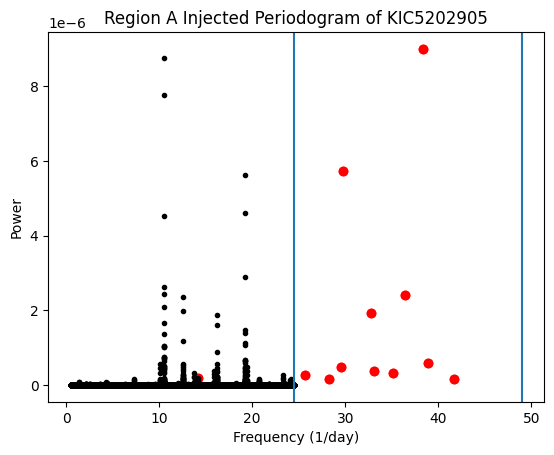

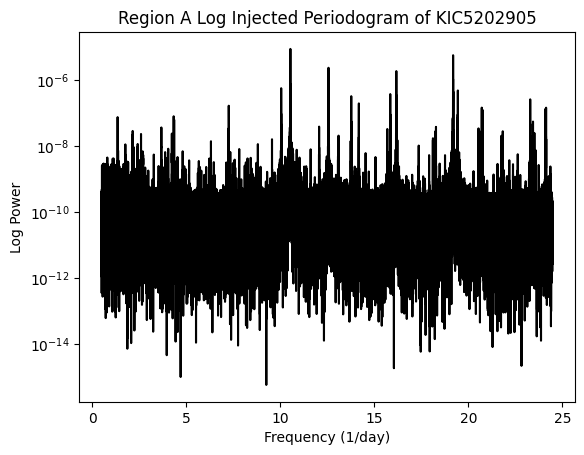

<Figure size 640x480 with 0 Axes>

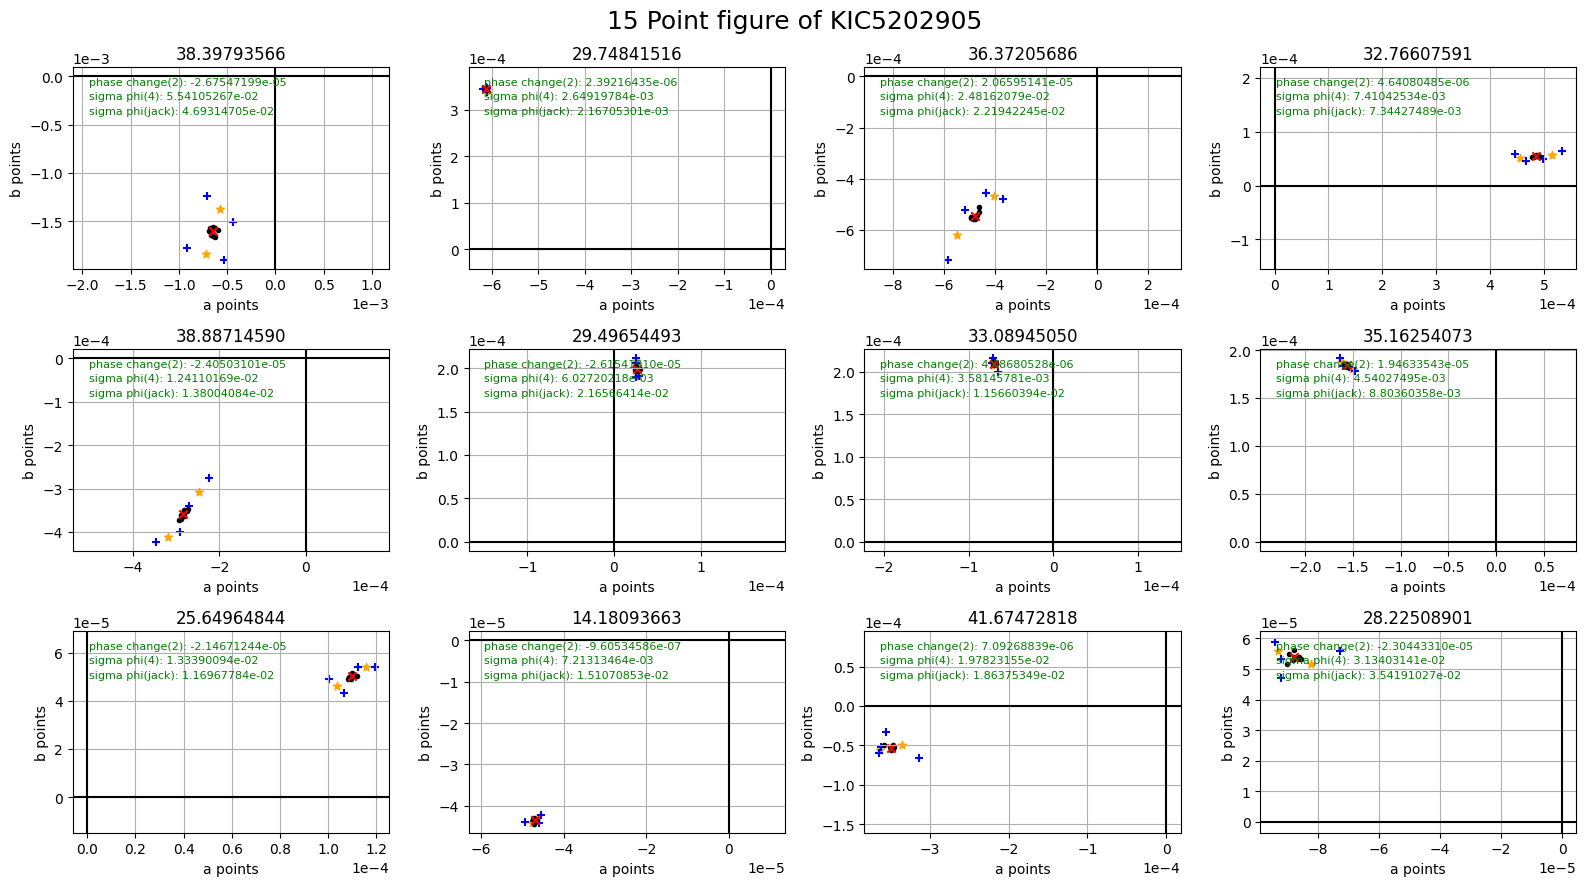

In [50]:
nana.star_search(5202905, True, True, inject_rng = rng, inject_amp = 1e-3) #plot, save, inject

In [57]:
nana.star_search(5559776, False, True) #plot, save, inject